In [66]:
import numpy as np
import pandas as pd
import scipy as sp
import random
import math

import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from tqdm.notebook import tqdm
from functools import partial

from sklearn.model_selection import GroupKFold
import category_encoders as ce

## Utils

In [3]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)

## Config

In [4]:
ID = 'Patient_Week'
TARGET = 'FVC'
SEED = 42
seed_everything(seed=SEED)

N_FOLD = 4

## Data Loading

In [5]:
path = '/home/prakhar/Desktop/ml/OSIC-Pulmonary-Fibrosis-Progression/input/'

In [6]:
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
ss = pd.read_csv(path + 'sample_submission.csv')

In [7]:
train.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


### Constructing input

In [8]:
train[ID] = train['Patient'].astype('str') + '_' + train['Weeks'].astype('str')
print(train.shape)
train.head()

(1549, 8)


,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,Patient_Week
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,ID00007637202177411956430_-4
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,ID00007637202177411956430_5
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,ID00007637202177411956430_7
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,ID00007637202177411956430_9
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,ID00007637202177411956430_11


In [9]:
output = pd.DataFrame()
gb = train.groupby('Patient')
tk0 = tqdm(gb, total=len(gb))

for _, usr_df in tk0:
    usr_output = pd.DataFrame()
    for week, tmp in usr_df.groupby('Weeks'):
        rename_cols = {'Weeks' : 'base_week', 'FVC' : 'base_FVC', 'Percent' : 'base_percent', 'Age' : 'base_age'}
        tmp = tmp.drop(columns='Patient_Week').rename(columns=rename_cols)
        drop_cols = ['Sex', 'SmokingStatus', 'Percent', 'Age']
        _usr_output = usr_df.drop(columns=drop_cols).rename(columns={'Weeks' : 'predict_week'}).merge(tmp, on='Patient')
        _usr_output['weeks_passed'] = _usr_output['predict_week'] - _usr_output['base_week']
        usr_output = pd.concat([usr_output, _usr_output])
    output = pd.concat([output, usr_output])

output.head()

,Patient,predict_week,FVC,Patient_Week,base_week,base_FVC,base_percent,base_age,Sex,SmokingStatus,weeks_passed
0,ID00007637202177411956430,-4,2315,ID00007637202177411956430_-4,-4,2315,58.253649,79,Male,Ex-smoker,0
1,ID00007637202177411956430,5,2214,ID00007637202177411956430_5,-4,2315,58.253649,79,Male,Ex-smoker,9
2,ID00007637202177411956430,7,2061,ID00007637202177411956430_7,-4,2315,58.253649,79,Male,Ex-smoker,11
3,ID00007637202177411956430,9,2144,ID00007637202177411956430_9,-4,2315,58.253649,79,Male,Ex-smoker,13
4,ID00007637202177411956430,11,2069,ID00007637202177411956430_11,-4,2315,58.253649,79,Male,Ex-smoker,15


In [10]:
train = output[output['weeks_passed'] != 0].reset_index(drop=True)
train.head()

,Patient,predict_week,FVC,Patient_Week,base_week,base_FVC,base_percent,base_age,Sex,SmokingStatus,weeks_passed
0,ID00007637202177411956430,5,2214,ID00007637202177411956430_5,-4,2315,58.253649,79,Male,Ex-smoker,9
1,ID00007637202177411956430,7,2061,ID00007637202177411956430_7,-4,2315,58.253649,79,Male,Ex-smoker,11
2,ID00007637202177411956430,9,2144,ID00007637202177411956430_9,-4,2315,58.253649,79,Male,Ex-smoker,13
3,ID00007637202177411956430,11,2069,ID00007637202177411956430_11,-4,2315,58.253649,79,Male,Ex-smoker,15
4,ID00007637202177411956430,17,2101,ID00007637202177411956430_17,-4,2315,58.253649,79,Male,Ex-smoker,21


In [11]:
# contructing test input
test = pd.read_csv(path + 'test.csv')
ss = pd.read_csv(path + 'sample_submission.csv')

test = test.rename(columns={'Weeks' : 'base_week', 'FVC' : 'base_FVC', 'Percent' : 'base_percent', 'Age' : 'base_age'})

ss['Patient'] = ss['Patient_Week'].apply(lambda x : x.split('_')[0])
ss['predict_week'] = ss['Patient_Week'].apply(lambda x : x.split('_')[1]).astype(int)

test = ss.drop(columns=['FVC', 'Confidence']).merge(test, on='Patient')
test['weeks_passed'] = test['predict_week'] - test['base_week']
print(test.shape)
test.head()

(730, 10)


,Patient_Week,Patient,predict_week,base_week,base_FVC,base_percent,base_age,Sex,SmokingStatus,weeks_passed
0,ID00419637202311204720264_-12,ID00419637202311204720264,-12,6,3020,70.186855,73,Male,Ex-smoker,-18
1,ID00419637202311204720264_-11,ID00419637202311204720264,-11,6,3020,70.186855,73,Male,Ex-smoker,-17
2,ID00419637202311204720264_-10,ID00419637202311204720264,-10,6,3020,70.186855,73,Male,Ex-smoker,-16
3,ID00419637202311204720264_-9,ID00419637202311204720264,-9,6,3020,70.186855,73,Male,Ex-smoker,-15
4,ID00419637202311204720264_-8,ID00419637202311204720264,-8,6,3020,70.186855,73,Male,Ex-smoker,-14


In [12]:
ss = pd.read_csv(path + 'sample_submission.csv')
ss.head()

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,2000,100
1,ID00421637202311550012437_-12,2000,100
2,ID00422637202311677017371_-12,2000,100
3,ID00423637202312137826377_-12,2000,100
4,ID00426637202313170790466_-12,2000,100


## Prepare Folds

In [13]:
folds = train[[ID, 'Patient', TARGET]].copy()
gfk = GroupKFold(n_splits=N_FOLD)
groups = folds['Patient'].values

for i, (train_idx, val_idx) in enumerate(gfk.split(folds, folds[TARGET], groups)):
    folds.loc[val_idx, 'fold'] = int(i)
folds.head()

,Patient_Week,Patient,FVC,fold
0,ID00007637202177411956430_5,ID00007637202177411956430,2214,2.0
1,ID00007637202177411956430_7,ID00007637202177411956430,2061,2.0
2,ID00007637202177411956430_9,ID00007637202177411956430,2144,2.0
3,ID00007637202177411956430_11,ID00007637202177411956430,2069,2.0
4,ID00007637202177411956430_17,ID00007637202177411956430,2101,2.0


In [14]:
folds['fold'] = folds['fold'].astype(int)
folds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12144 entries, 0 to 12143
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Patient_Week  12144 non-null  object
 1   Patient       12144 non-null  object
 2   FVC           12144 non-null  int64 
 3   fold          12144 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 379.6+ KB


## Model

In [28]:
def run_single_lightgbm(param, train_df, test_df, folds, features, target, fold_num=0, categorical=[]):
    
    train_idx = folds[folds.fold != fold_num].index
    val_idx = folds[folds.fold == fold_num].index
    
    if categorical == []:
        train_data = lgb.Dataset(train_df.iloc[train_idx][features],
                                 label=target.iloc[train_idx])
        val_data = lgb.Dataset(train_df.iloc[val_idx][features], 
                               label=target.iloc[val_idx])
    else :
        train_data = lgb.Dataset(train_df.iloc[train_idx][features],
                                 label=target.iloc[train_idx],
                                 categorical_feature=categorical)
        val_data = lgb.Dataset(train_df.iloc[val_idx][features], 
                               label=target.iloc[val_idx],
                               categorical_feature=categorical)
    
    y_oof = np.zeros(len(train_df))
    predictions = np.zeros(len(test_df))
    
    num_round = 100000
    
    clf = lgb.train(param, 
                    train_data,
                    num_round,
                    valid_sets=[train_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds=100)
    
    y_oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance(importance_type="gain")
    fold_importance_df['fold'] = fold_num
    
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration)
    
    return y_oof, predictions, fold_importance_df

In [25]:
def run_kfold_lightgbm(param, train_df, test_df, folds, features, target, n_folds=5, categorical=[]):
    
    y_oof = np.zeros(len(train_df))
    predictions = np.zeros(len(test_df))
    feature_importance_df = pd.DataFrame()
    
    for fold_ in range(n_folds):
        print(f'fold {fold_}')
        _y_oof, _predictions, fold_importance_df = run_single_lightgbm(param,
                                                                       train_df,
                                                                       test_df, 
                                                                       folds,
                                                                       features,
                                                                       target,
                                                                       fold_num=fold_,
                                                                       categorical=categorical)
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        y_oof += _y_oof
        predictions += _predictions / n_folds
        
    return y_oof, predictions, feature_importance_df

In [45]:
def show_feature_importance(feature_importance_df, name):
    cols = (feature_importance_df[['Feature', 'importance']]
            .groupby('Feature')
            .mean()
            .sort_values(by='importance', ascending=False)[:50].index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]
    
    plt.figure(figsize=(6, 4))
    sns.barplot(x='importance', y='Feature', data=best_features.sort_values(by='importance', ascending=False))
    plt.title('Features importance (averaged/folds)')

## FVC Prediction

/home/prakhar/.local/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


fold 0
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 368.79	valid_1's rmse: 377.099
[200]	training's rmse: 236.503	valid_1's rmse: 233.719
[300]	training's rmse: 201.557	valid_1's rmse: 201.219
[400]	training's rmse: 188.765	valid_1's rmse: 196.974
[500]	training's rmse: 181.299	valid_1's rmse: 197.471
Early stopping, best iteration is:
[412]	training's rmse: 187.619	valid_1's rmse: 196.872
fold 1


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 352.172	valid_1's rmse: 486.428
[200]	training's rmse: 218.824	valid_1's rmse: 369.348
[300]	training's rmse: 184.234	valid_1's rmse: 345.669
[400]	training's rmse: 171.032	valid_1's rmse: 343.109
[500]	training's rmse: 163.658	valid_1's rmse: 341.867
[600]	training's rmse: 157.318	valid_1's rmse: 343.367
Early stopping, best iteration is:
[504]	training's rmse: 163.357	valid_1's rmse: 341.669
fold 2


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 376.869	valid_1's rmse: 326.015
[200]	training's rmse: 222.394	valid_1's rmse: 269.394
[300]	training's rmse: 182.202	valid_1's rmse: 267.478
Early stopping, best iteration is:
[257]	training's rmse: 193.451	valid_1's rmse: 267.232
fold 3


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 359.016	valid_1's rmse: 395.148
[200]	training's rmse: 223.736	valid_1's rmse: 288.784
[300]	training's rmse: 189.344	valid_1's rmse: 279.07
[400]	training's rmse: 176.706	valid_1's rmse: 279.875
Early stopping, best iteration is:
[316]	training's rmse: 186.664	valid_1's rmse: 278.945


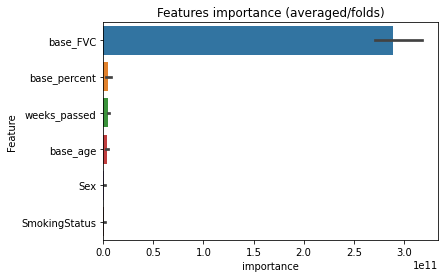

In [31]:
target = train[TARGET]
test[TARGET] = np.nan

cat_features = ['Sex', 'SmokingStatus']
num_featues = [f for f in test.columns if (test.dtypes[f] != 'object') and (f not in cat_features)]
features = cat_features + num_featues
drop_features = [ID, TARGET, 'predict_week', 'base_week']
features = [f for f in features if f not in drop_features]

if cat_features:
    ce_oe = ce.OrdinalEncoder(cols=cat_features, handle_unknown='impute')
    ce_oe.fit(train)
    train = ce_oe.transform(train)
    test = ce_oe.transform(test)
    
lgb_param = {'objective': 'regression',
             'metric': 'rmse',
             'boosting_type': 'gbdt',
             'learning_rate': 0.01,
             'seed': SEED,
             'max_depth': -1,
             'verbosity': -1,
             'device': 'gpu',
             'gpu_platform_id': 0,
             'gpu_device_id': 0
            }

y_oof, predictions, feature_importance_df = run_kfold_lightgbm(lgb_param, train, test, folds, features, target, 
                                                               n_folds=N_FOLD, categorical=cat_features)
show_feature_importance(feature_importance_df, TARGET)

In [32]:
train['FVC_pred'] = y_oof
test['FVC_pred'] = predictions

## Confidence labels

In [63]:
train['Confidence'] = 100
train['sigma_clipped'] = train['Confidence'].apply(lambda x: max(x, 70))
train['diff'] = abs(train['FVC'] - train['FVC_pred'])
train['delta'] = train['diff'].apply(lambda x: min(x, 1000))
train['score'] = -np.sqrt(2)*train['delta'] / train['sigma_clipped'] - np.log(np.sqrt(2) * train['sigma_clipped'])
score = train['score'].mean()
print(score)

-7.447078338015998


In [67]:
train.head()

,Patient,predict_week,FVC,Patient_Week,base_week,base_FVC,base_percent,base_age,Sex,SmokingStatus,weeks_passed,FVC_pred,Confidence,sigma_clipped,diff,delta,score
0,ID00007637202177411956430,5,2214,ID00007637202177411956430_5,-4,2315,58.253649,79,1,1,9,2235.482872,100,100,21.482872,21.482872,-5.255557
1,ID00007637202177411956430,7,2061,ID00007637202177411956430_7,-4,2315,58.253649,79,1,1,11,2235.482872,100,100,174.482872,174.482872,-7.419304
2,ID00007637202177411956430,9,2144,ID00007637202177411956430_9,-4,2315,58.253649,79,1,1,13,2244.978287,100,100,100.978287,100.978287,-6.379792
3,ID00007637202177411956430,11,2069,ID00007637202177411956430_11,-4,2315,58.253649,79,1,1,15,2244.978287,100,100,175.978287,175.978287,-7.440453
4,ID00007637202177411956430,17,2101,ID00007637202177411956430_17,-4,2315,58.253649,79,1,1,21,2244.978287,100,100,143.978287,143.978287,-6.987904


In [68]:
def loss_func(weight, row):
    confidence = weight
    sigma_clipped = max(confidence, 70)
    diff = abs(row['FVC'] - row['FVC_pred'])
    delta = min(diff, 1000)
    score = -math.sqrt(2)*delta/sigma_clipped - np.log(math.sqrt(2)*sigma_clipped)
    return -score

results = []
tk0 = tqdm(train.iterrows(), total=len(train))
for _, row in tk0:
    loss_partial = partial(loss_func, row=row)
    weight = [100]

    result = sp.optimize.minimize(loss_partial, weight, method='SLSQP')
    x = result['x']
    results.append(x[0])

In [70]:
# optimized score
train['Confidence'] = results
train['sigma_clipped'] = train['Confidence'].apply(lambda x: max(x, 70))
train['diff'] = abs(train['FVC'] - train['FVC_pred'])
train['delta'] = train['diff'].apply(lambda x: min(x, 1000))
train['score'] = -np.sqrt(2)*train['delta']/train['sigma_clipped'] - np.log(np.sqrt(2)*train['sigma_clipped'])
score = train['score'].mean()
print(score)
train.head()

-6.442136166289217


,Patient,predict_week,FVC,Patient_Week,base_week,base_FVC,base_percent,base_age,Sex,SmokingStatus,weeks_passed,FVC_pred,Confidence,sigma_clipped,diff,delta,score
0,ID00007637202177411956430,5,2214,ID00007637202177411956430_5,-4,2315,58.253649,79,1,1,9,2235.482872,54.486858,70.000000,21.482872,21.482872,-5.029088
1,ID00007637202177411956430,7,2061,ID00007637202177411956430_7,-4,2315,58.253649,79,1,1,11,2235.482872,246.690545,246.690545,174.482872,174.482872,-6.854974
2,ID00007637202177411956430,9,2144,ID00007637202177411956430_9,-4,2315,58.253649,79,1,1,13,2244.978287,142.764027,142.764027,100.978287,100.978287,-6.308053
3,ID00007637202177411956430,11,2069,ID00007637202177411956430_11,-4,2315,58.253649,79,1,1,15,2244.978287,248.793904,248.793904,175.978287,175.978287,-6.863508
4,ID00007637202177411956430,17,2101,ID00007637202177411956430_17,-4,2315,58.253649,79,1,1,21,2244.978287,203.415549,203.415549,143.978287,143.978287,-6.662810


## Confidence Prediction

fold 0
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 222.885	valid_1's rmse: 192.758
Early stopping, best iteration is:
[1]	training's rmse: 273.667	valid_1's rmse: 185.26
fold 1
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 200.369	valid_1's rmse: 287.825


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1098: UserWarning:

Early stopping, best iteration is:
[66]	training's rmse: 209.295	valid_1's rmse: 287.128
fold 2
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 199.761	valid_1's rmse: 259.608
Early stopping, best iteration is:
[9]	training's rmse: 247.161	valid_1's rmse: 252.442
fold 3
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 204.123	valid_1's rmse: 264.257


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1098: UserWarning:

[200]	training's rmse: 187.982	valid_1's rmse: 259.075
[300]	training's rmse: 178.632	valid_1's rmse: 254.951
[400]	training's rmse: 172.372	valid_1's rmse: 255.738
Early stopping, best iteration is:
[347]	training's rmse: 175.389	valid_1's rmse: 254.885


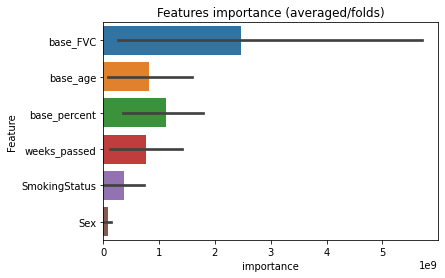

In [71]:
TARGET = 'Confidence'

target = train[TARGET]
test[TARGET] = np.nan

# features
cat_features = ['Sex', 'SmokingStatus']
num_features = [f for f in test.columns if (test.dtypes[f] != 'object') & (f not in cat_features)]
features = num_features + cat_features
drop_features = [ID, TARGET, 'predict_week', 'base_week', 'FVC', 'FVC_pred']
features = [f for f in features if f not in drop_features]

lgb_param = {'objective': 'regression',
             'metric': 'rmse',
             'boosting_type': 'gbdt',
             'learning_rate': 0.01,
             'seed': SEED,
             'max_depth': -1,
             'verbosity': -1,
            }

y_oof, predictions, feature_importance_df = run_kfold_lightgbm(lgb_param, train, test, folds, features, target, 
                                                             n_folds=N_FOLD, categorical=cat_features)
    
show_feature_importance(feature_importance_df, TARGET)

In [73]:
train['Confidence'] = y_oof
train['sigma_clipped'] = train['Confidence'].apply(lambda x: max(x, 70))
train['diff'] = abs(train['FVC'] - train['FVC_pred'])
train['delta'] = train['diff'].apply(lambda x: min(x, 1000))
train['score'] = -math.sqrt(2)*train['delta']/train['sigma_clipped'] - np.log(math.sqrt(2)*train['sigma_clipped'])
score = train['score'].mean()
print(score)

-6.8468884528337295


In [74]:
test['Confidence'] = predictions

## Submission

In [76]:
sub = ss.drop(columns=['FVC', 'Confidence']).merge(test[['Patient_Week', 'FVC_pred', 'Confidence']], 
                                                           on='Patient_Week')
sub.columns = ss.columns
sub.to_csv('submission.csv', index=False)
sub.head()

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,2972.967682,242.353575
1,ID00421637202311550012437_-12,2850.083650,224.196995
2,ID00422637202311677017371_-12,1980.371835,223.417561
3,ID00423637202312137826377_-12,3373.370434,260.285753
4,ID00426637202313170790466_-12,2951.259974,231.619715
